In [1]:
#imports
from PIL import Image, ImageDraw
#import image_slicer
import numpy as np
import cv2
import skimage
from scipy import ndimage as ndi
from skimage import feature, color,io
from skimage.morphology import square
import matplotlib.pyplot as plt
import math


In [ ]:
#read in hand image

# Read Image
img = plt.imread('hand.png')

img = plt.imread('jojo4_bottom.jpg')
#img=img[:,:,0] 
# Filter by color
img = skimage.filters.meijering(img)
# Turn to gray
gray = color.rgb2gray(img)

# Threshold and turn to binary
threshold = skimage.filters.threshold_otsu(gray)
binary = (gray >= threshold)

# Filter noise -erosion filter
out = ndi.morphology.binary_erosion(binary, iterations=4)

# Show image
plt.imshow(out)
plt.axis('off')

(-0.5, 751.5, 559.5, -0.5)

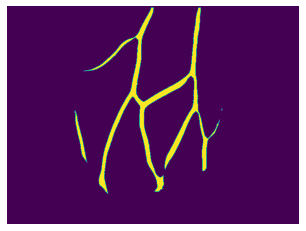

In [53]:
# Copy Image
out1=out

# Close gaps
closing=skimage.morphology.area_closing(binary,100000,connectivity=2)
# Find Edges
edges = feature.canny(closing,sigma=1)
# make edge bigger
img2=skimage.morphology.dilation(edges,square(40))

#Convert 
img2=img2*1
out1=out1*1

# Combine masks
combined = cv2.bitwise_xor(img2, out1) 
combined = cv2.bitwise_and(combined, out1)

# Filter noise -erosion filter (don't need)
#filt = ndi.morphology.binary_erosion(combined, iterations=3)
# Show image
plt.imshow(combined)
plt.axis('off')
#plt.savefig('hand_bin.png', dpi = 300)

(-0.5, 751.5, 559.5, -0.5)

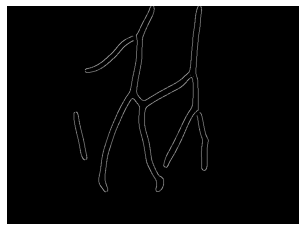

In [54]:
edges = feature.canny(combined, sigma = 6, low_threshold = 0.05, high_threshold = 0.2)
#edges = ndi.morphology.binary_erosion(edges, iterations=0)

plt.imshow(edges, cmap=plt.cm.gray)
plt.axis('off')

Text(0.5, 1.0, 'Probabilistic Hough')

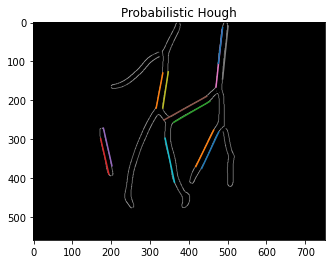

In [55]:
from skimage.transform import probabilistic_hough_line
# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=15, line_length=90, line_gap=15)
# SHow previous image
plt.imshow(edges, cmap=plt.cm.gray)
slope=[]
# plot new lines
for line in lines:
    # Calculate Radius between parallel line to find thickest veins
        p0, p1 = line
        slope.append(abs(p0[0]-p1[0])/abs(p0[1]-p1[1])) # calculate slope of each line 
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
        
#plt.axis('off')
plt.title('Probabilistic Hough')

In [36]:
def mid_line_dist(line1,line2):
    # find mid point of line
    p0,p1=line1
    xa,xb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    p0,p1=line2
    ya,yb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2


    return math.dist((ya,yb),(xa,xb))

In [56]:
# Find Parallel Lines that are ~close~
thresh =0.09
thick=0
thick=[-1]*len(lines)
ind_parallel=[-1]*len(lines)
# loop through all slopes
for i in range(len(slope)):
    # compare slope i to all pther slopes
    for j in range(0,len(slope)):
        if j==i:
            continue
       
        if abs(slope[i]-slope[j])<thresh and mid_line_dist(lines[i],lines[j])<40 :
            ind_parallel[i]=j # provides index
            
            # get all thicknesses
            thick[i]=(mid_line_dist(lines[i],lines[j]))
            break

In [12]:
def plot_connect(line1,line2):
    p0,p1=line1
    xa,xb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    p0,p1=line2
    ya,yb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    plt.plot((xa,ya),(xb,yb))
    return

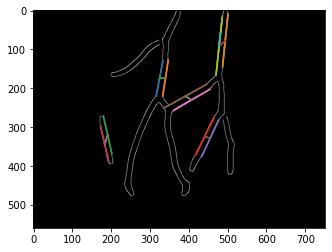

In [57]:
# SHow previous image
plt.imshow(edges, cmap=plt.cm.gray)

# plot parallels and connectors
for i in range(len(lines)):
    if ind_parallel[i]==-1:
        continue
    else:
        
        line1=lines[i]
        p0, p1 = line1
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
        
        line2=lines[ind_parallel[i]]
        p0, p1 = line2
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
        
        plot_connect(line1,line2)
        

In [14]:
def get_mid(line1,line2):
    p0,p1=line1
    xa,xb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    p0,p1=line2
    ya,yb=(p0[0]+p1[0])/2,(p0[1]+p1[1])/2
    
    xf=(xa+ya)/2
    yf=(yb+xb)/2
    return (xf,yf)

(-0.5, 751.5, 559.5, -0.5)

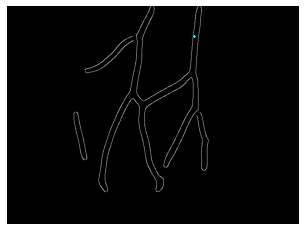

In [58]:
# plot access point thickest vein
# SHow previous image

plt.imshow(edges, cmap=plt.cm.gray)
b_ind=thick.index(max(thick))

line1=lines[b_ind]
p0, p1 = line1
#plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

line2=lines[ind_parallel[b_ind]]
p0, p1 = line2
#plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

pnt=get_mid(line1,line2)


plt.plot(pnt[0],pnt[1], marker='*', markersize=2, color="cyan")
plt.axis('off')

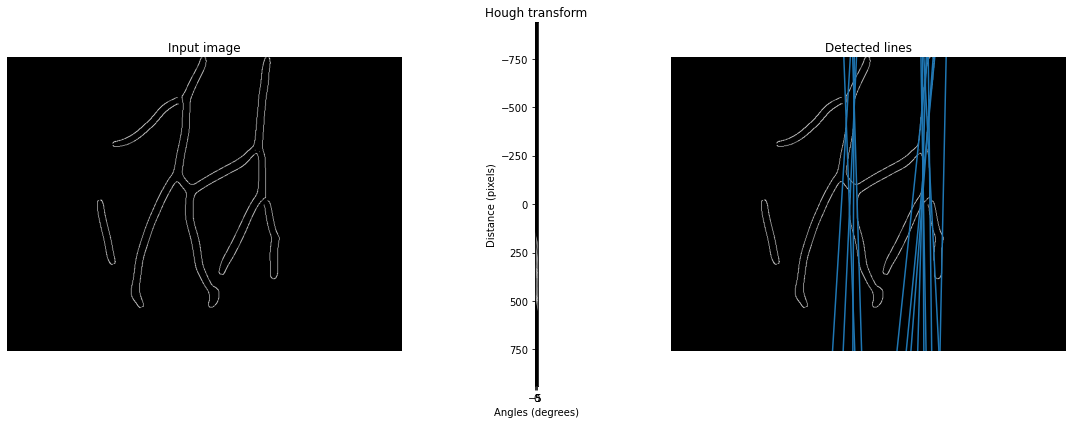

In [70]:
# ignore 

from skimage.transform import hough_line, hough_line_peaks

tested_angles = np.linspace(-np.pi / 30, np.pi / 30, 180, endpoint=False)
h, theta, d = hough_line(edges, theta=tested_angles)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(edges, cmap=plt.cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=plt.cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(edges, cmap=plt.cm.gray)
ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()

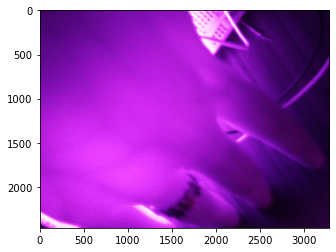

In [3]:
# Read Image
img = plt.imread('jojo4_bottom.jpg')

plt.imshow(img)

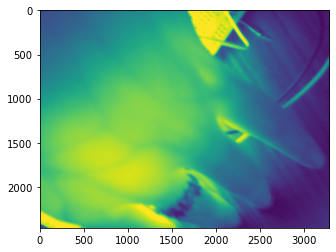

In [7]:
img = plt.imread('jojo4_bottom.jpg')
red=img[:,:,0] 
plt.imshow(red)

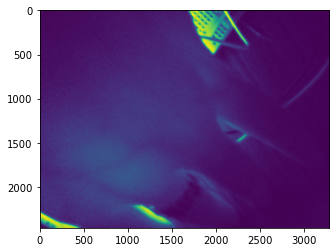

In [8]:
img = plt.imread('jojo4_bottom.jpg')
green=img[:,:,1] 
plt.imshow(green)

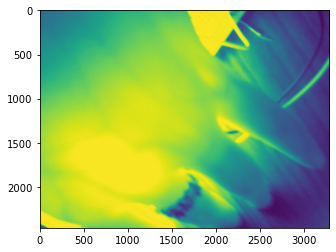

In [11]:
img = plt.imread('jojo4_bottom.jpg')
blue=img[:,:,2] 
plt.imshow(blue)